In [1]:
import sys  ###graphslam1
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def draw(xs, ms, zlist): #msを追加 ###graphslam2draw
    ##世界の描画##
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111) 
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    
    ##軌跡の描画##
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")

    ##センサ値の描画##
    for t in range(len(xs)):
        if t not in zlist: continue
            
        for obs in zlist[t]:
            x, y, theta = xs[t]
            ell, phi = obs[1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
        
    ##ランドマークの推定位置の描画###  #追加
    ax.scatter([e[0] for e in ms], [e[1] for e in ms], s=10, marker="*", color="blue")
    print(ms)
    
    
    ##描画実行##
    plt.show()

In [3]:
###データの読み込み###
delta = 0.0
xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
zlist = {} #センサ値のデータ（ステップ数をキーにして、さらにその中にランドマークのIDとセンサ値をタプルで保存）
us = {}    #制御入力のデータ（ステップ数をキーにして保存）

with open("log.txt") as f:
    for line in f.readlines():
        tmp = line.rstrip().split()
        
        step = int(tmp[1])
        if tmp[0] == "delta":
            delta = float(tmp[1])
        elif tmp[0] == "x": #姿勢のレコードの場合
            xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
        elif tmp[0] == "z": #センサ値のレコードの場合
            if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                zlist[step] = []
            zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4])]).T))
        elif tmp[0] == "u": #制御入力の場合
            us[step] = np.array([float(tmp[2]), float(tmp[3])]).T

In [4]:
##空の精度行列と一次の項のベクトルの準備##  ###graphslam2preparebigmatrix
t_end = len(xs) - 1 #step数（数式中のT）

##観測されたランドマークのリスト（精度行列に設けるもの）のセット##
observed_landmarks = set()
for t in range(len(xs)):
    if t not in zlist: continue

    for obs in zlist[t]:
        observed_landmarks.add(obs[0])

##精度行列の次元を求めて精度行列と一次の項のベクトルの初期化##
dim = (t_end + 1)*3 + len(observed_landmarks)*2
OMEGA = np.zeros((dim, dim))
xi = np.zeros((dim, 1))

##確認###
print(t_end)                           #終了時刻
print(observed_landmarks) #観測されたランドマークのID
print(OMEGA)                        #精度行列
print(xi)                                  #一次の項のベクトル

31
{0, 1, 2, 3, 4, 5}
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [5]:
mxs, mys = {}, {} #ランドマークごとにx座標を貯める辞書      ###graphslam2initlandmarkpos
for j in observed_landmarks: mxs[j], mys[j] = [], [] #ランドマークごとに座標のリストを初期化

for t in range(len(xs)):
    if t not in zlist: continue  #センサ値のないステップは飛ばす
            
    for obs in zlist[t]:             #センサ値ごとに地図上の位置を計算
        x, y, theta = xs[t]         #デッドレコニング上の座標
        ell, phi = obs[1]            #センサ値
        j = obs[0]                      #ランドマークのID
        mx = x + ell*math.cos(theta + phi)    #ランドマークの座標
        my = y + ell*math.sin(theta + phi)    #ランドマークの座標
        
        mxs[j].append(mx)     #計算した座標をリストに加える
        mys[j].append(my)
        
mx_avg, my_avg = {}, {}
hat_ms = []
for j in observed_landmarks:  #ランドマークごとに平均値を出す
    mx_avg[j] = sum(mxs[j])/len(mxs[j])
    my_avg[j] = sum(mys[j])/len(mys[j])
    hat_ms.append(np.array([mx_avg[j], my_avg[j]]).T)
    
hat_xs = xs  #姿勢の初期値はxsをそのまま使う
hat_ms = hat_ms

print(hat_ms)

[array([-2.13800045,  3.38554522]), array([-1.51314626, -4.10141355]), array([ 3.46510084, -0.17765306]), array([1.91972816, 2.59158263]), array([ 0.72851143, -0.58363871]), array([-3.62358709,  0.93716617])]


[array([-2.13800045,  3.38554522]), array([-1.51314626, -4.10141355]), array([ 3.46510084, -0.17765306]), array([1.91972816, 2.59158263]), array([ 0.72851143, -0.58363871]), array([-3.62358709,  0.93716617])]


<IPython.core.display.Javascript object>


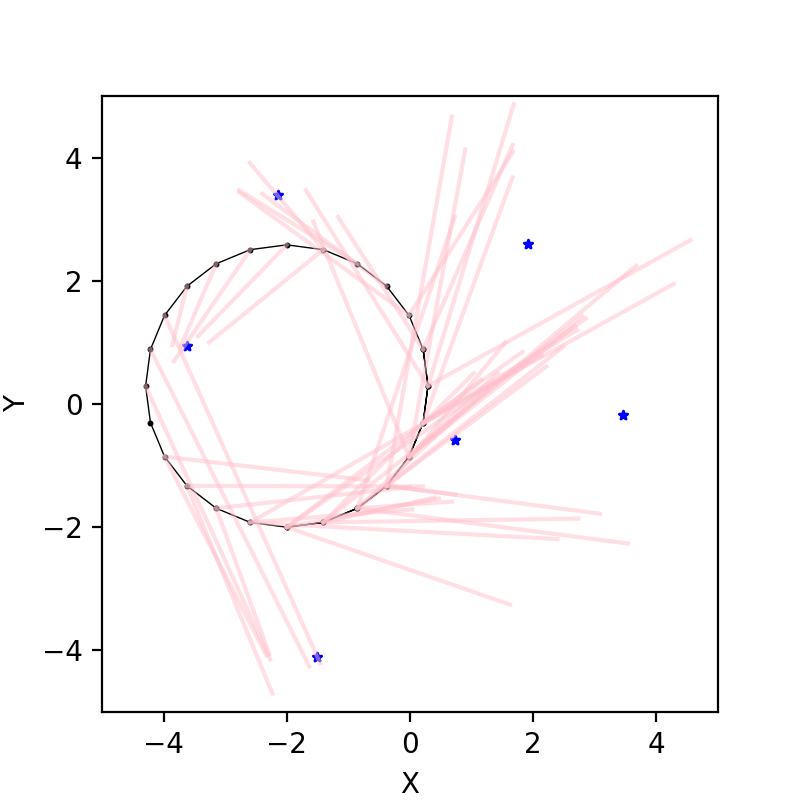

In [6]:
draw(hat_xs, hat_ms, zlist) #xsをhat_xsに。hat_msを追加 ###graphslam2calldraw